In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [88]:
data = pd.read_csv("../data/external/ihsg 14-12-22 till 22-04-24.csv")
# data = pd.read_csv("../data/external/5 tahun.csv")
sentiment = pd.read_csv("../data/processed/preprocces-data.csv")

data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-14,6810.355957,6854.098145,6774.131836,6801.749023,6801.749023,215430000
1,2022-12-15,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,145093400
2,2022-12-16,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,156126900
3,2022-12-19,6812.153809,6827.814941,6754.087891,6779.698242,6779.698242,127896600
4,2022-12-20,6779.698242,6792.203125,6715.044922,6768.315918,6768.315918,151817000


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       319 non-null    object 
 1   Open       319 non-null    float64
 2   High       319 non-null    float64
 3   Low        319 non-null    float64
 4   Close      319 non-null    float64
 5   Adj Close  319 non-null    float64
 6   Volume     319 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 17.6+ KB


In [90]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,319.000000,319.000000,319.000000,319.000000,319.000000,3.190000e+02
mean,6942.464352,6975.159285,6909.168131,6942.480123,6942.480123,1.640772e+08
std,212.363379,210.694990,211.872057,211.116154,211.116154,5.091075e+07
min,6565.728027,6622.794922,6542.791992,6565.728027,6565.728027,9.486010e+07
25%,6799.167969,6825.356445,6759.051514,6799.379394,6799.379394,1.373428e+08
50%,6893.275879,6925.014160,6863.670898,6894.716797,6894.716797,1.544207e+08
75%,7107.524658,7140.869141,7053.836914,7097.227539,7097.227539,1.757511e+08
max,7422.301758,7454.448242,7392.011230,7433.314941,7433.314941,6.150719e+08


In [91]:
# Menghitung return manual berdasarkan harga penutupan (Close)
data['Return'] = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1) * 100

In [92]:
sentiment


sentiment_mapping = {"positive": 0, "negative": 1, "neutral": 2}

data['Sentiment'] = sentiment['sentiment'].map(sentiment_mapping)

In [93]:
lengh_data = len(data)
split_ratio = 0.8
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data -lengh_train

In [94]:
data = data.drop(["Volume"],axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")

In [95]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
    """
    Mengubah data time series menjadi data supervised learning.

    Argumen:
    data: DataFrame, dataset time series yang akan diubah.
    n_in: int, jumlah timestep mundur sebagai input (X).
    n_out: int, jumlah timestep maju sebagai output (y).
    dropnan: bool, apakah akan menghapus baris dengan nilai NaN.
    var_names: list of str, nama variabel untuk setiap kolom.

    Returns:
    DataFrame yang sudah diubah menjadi format supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if var_names is None:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]
    
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if var_names is None:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t)') for j in range(n_vars)]
        else:
            if var_names is None:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]
    
    # Concatenate semua kolom
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Hapus baris dengan nilai NaN
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Contoh penggunaan:
# Misalkan 'data' adalah DataFrame yang berisi data time series
# dengan tiga fitur, dan kita ingin menggunakan 3 timestep mundur sebagai input
# dan 1 timestep maju sebagai output, dan nama variabel untuk setiap fitur adalah
# 'A', 'B', dan 'C'

var_names = data.columns
data_supervised = time_series_to_supervised(data, n_in=15, n_out=1, var_names=var_names)


In [96]:
# Split data menjadi train dan validation
train_data = data_supervised[:lengh_train]
validation_data = data_supervised[lengh_train:]

In [97]:
data_supervised

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-1),Return(t-1),Sentiment(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t),Return(t),Sentiment(t)
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-05,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,-0.733475,1.0,6751.859863,6812.192871,6693.765137,...,6813.238770,-1.096265,0.0,6813.279785,6813.421875,6621.986816,6653.840820,6653.840820,-2.339533,1
2023-01-06,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,0.893576,1.0,6812.153809,6827.814941,6754.087891,...,6653.840820,-2.339533,1.0,6653.759766,6708.637207,6598.645996,6684.558105,6684.558105,0.461647,2
2023-01-09,6812.153809,6827.814941,6754.087891,6779.698242,6779.698242,-0.477007,1.0,6779.698242,6792.203125,6715.044922,...,6684.558105,0.461647,2.0,6684.558105,6726.965820,6638.645996,6688.265137,6688.265137,0.055457,1
2023-01-10,6779.698242,6792.203125,6715.044922,6768.315918,6768.315918,-0.167888,1.0,6768.315918,6820.663086,6763.696777,...,6688.265137,0.055457,1.0,6688.265137,6690.229004,6570.243164,6622.499023,6622.499023,-0.983306,1
2023-01-11,6768.315918,6820.663086,6763.696777,6820.663086,6820.663086,0.773415,1.0,6820.702148,6844.121094,6800.617188,...,6622.499023,-0.983306,1.0,6622.539063,6622.794922,6557.919922,6584.453125,6584.453125,-0.574495,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7405.566895,7454.448242,7380.647949,7433.314941,7433.314941,0.163153,2.0,7408.658203,7416.338867,7308.035156,...,7254.398926,1.221663,2.0,7245.321777,7298.858887,7239.273926,7286.881836,7286.881836,0.447768,2
2024-04-16,7408.658203,7416.338867,7308.035156,7328.054199,7328.054199,-1.416067,1.0,7338.076172,7358.550781,7300.940918,...,7286.881836,0.447768,2.0,7130.627930,7188.088867,7066.573242,7164.807129,7164.807129,-1.675267,0
2024-04-17,7338.076172,7358.550781,7300.940918,7302.449219,7302.449219,-0.349410,1.0,7320.538086,7361.529785,7314.180176,...,7164.807129,-1.675267,0.0,7199.830078,7234.374023,7130.840820,7130.840820,7130.840820,-0.474072,1


In [98]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi data train
scaled_train_data = scaler.fit_transform(train_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)


In [99]:
scaled_train_data

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-1),Return(t-1),Sentiment(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t),Return(t),Sentiment(t)
0,0.291232,0.229312,0.245304,0.234413,0.234413,0.396253,0.5,0.229634,0.242574,0.186888,...,0.311713,0.306744,0.0,0.305408,0.244148,0.098034,0.110968,0.110968,0.000000,0.5
1,0.229634,0.242574,0.186888,0.310395,0.310395,0.797686,0.5,0.304019,0.262583,0.261561,...,0.110968,0.000000,0.5,0.108606,0.109944,0.069141,0.149653,0.149653,0.691119,1.0
2,0.304019,0.262583,0.261561,0.269472,0.269472,0.459530,0.5,0.263978,0.216972,0.213230,...,0.149653,0.691119,1.0,0.146602,0.133418,0.118657,0.154322,0.154322,0.590902,0.5
3,0.263978,0.216972,0.213230,0.255137,0.255137,0.535797,0.5,0.249936,0.253423,0.273456,...,0.154322,0.590902,0.5,0.151176,0.086367,0.033981,0.071497,0.071497,0.334614,0.5
4,0.249936,0.253423,0.273456,0.321063,0.321063,0.768039,0.5,0.314565,0.283467,0.319159,...,0.071497,0.334614,0.5,0.070089,0.000000,0.018727,0.023582,0.023582,0.435478,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.914655,0.879869,0.887430,0.890475,0.890475,0.472193,1.0,0.866894,0.897551,0.869956,...,0.833305,0.490255,1.0,0.823437,0.800649,0.807300,0.859156,0.859156,0.647291,1.0
251,0.866894,0.897551,0.869956,0.954441,0.954441,0.749524,1.0,0.925756,0.895362,0.907474,...,0.859156,0.647291,1.0,0.822626,0.811280,0.815815,0.869610,0.869610,0.605476,0.0
252,0.925756,0.895362,0.907474,0.898402,0.898402,0.427313,0.0,0.893625,0.958576,0.913085,...,0.869610,0.605476,0.0,0.851315,0.831426,0.776782,0.833836,0.833836,0.480635,0.0
253,0.893625,0.958576,0.913085,1.000000,1.000000,0.850658,0.0,1.000000,1.000000,1.000000,...,0.833836,0.480635,0.0,0.801666,0.808067,0.783979,0.771142,0.771142,0.407289,0.0


In [100]:
# Target (Return(t)) dan input (X) untuk training
y_train_scaled = scaled_train_data[["Return(t)"]]  # Ambil kolom Open(t) sebagai target
X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)","Sentiment(t)", "Return(t)"], axis=1)

In [101]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Columns: 105 entries, Open(t-15) to Sentiment(t-1)
dtypes: float64(105)
memory usage: 209.3 KB


In [102]:
y_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Return(t)  255 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [103]:
X_train_scaled

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-2),Return(t-2),Sentiment(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Adj Close(t-1),Return(t-1),Sentiment(t-1)
0,0.291232,0.229312,0.245304,0.234413,0.234413,0.396253,0.5,0.229634,0.242574,0.186888,...,0.406821,0.713254,1.0,0.398577,0.355807,0.334783,0.311713,0.311713,0.306744,0.0
1,0.229634,0.242574,0.186888,0.310395,0.310395,0.797686,0.5,0.304019,0.262583,0.261561,...,0.311713,0.306744,0.0,0.305408,0.244148,0.098034,0.110968,0.110968,0.000000,0.5
2,0.304019,0.262583,0.261561,0.269472,0.269472,0.459530,0.5,0.263978,0.216972,0.213230,...,0.110968,0.000000,0.5,0.108606,0.109944,0.069141,0.149653,0.149653,0.691119,1.0
3,0.263978,0.216972,0.213230,0.255137,0.255137,0.535797,0.5,0.249936,0.253423,0.273456,...,0.149653,0.691119,1.0,0.146602,0.133418,0.118657,0.154322,0.154322,0.590902,0.5
4,0.249936,0.253423,0.273456,0.321063,0.321063,0.768039,0.5,0.314565,0.283467,0.319159,...,0.154322,0.590902,0.5,0.151176,0.086367,0.033981,0.071497,0.071497,0.334614,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.914655,0.879869,0.887430,0.890475,0.890475,0.472193,1.0,0.866894,0.897551,0.869956,...,0.865502,0.756531,1.0,0.870526,0.839137,0.777410,0.833305,0.833305,0.490255,1.0
251,0.866894,0.897551,0.869956,0.954441,0.954441,0.749524,1.0,0.925756,0.895362,0.907474,...,0.833305,0.490255,1.0,0.823437,0.800649,0.807300,0.859156,0.859156,0.647291,1.0
252,0.925756,0.895362,0.907474,0.898402,0.898402,0.427313,0.0,0.893625,0.958576,0.913085,...,0.859156,0.647291,1.0,0.822626,0.811280,0.815815,0.869610,0.869610,0.605476,0.0
253,0.893625,0.958576,0.913085,1.000000,1.000000,0.850658,0.0,1.000000,1.000000,1.000000,...,0.869610,0.605476,0.0,0.851315,0.831426,0.776782,0.833836,0.833836,0.480635,0.0


In [104]:
from sklearn import svm

params =  {'C': 10, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
model_svm = svm.SVR(**params)
model_svm.fit(X_train_scaled,train_data["Return(t)"])

SVR(C=10, epsilon=0.001, kernel='linear')

In [105]:
y_pred = model_svm.predict(X_train_scaled)

In [106]:
mse = np.mean((y_pred - train_data['Return(t)'])**2)

#Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.31763924327314064
RMSE: 0.563594928360024


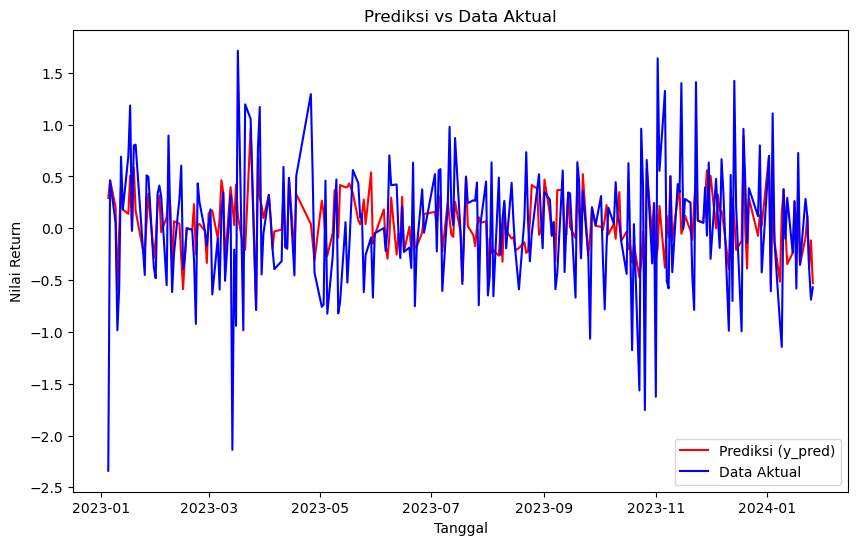

In [107]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Return(t)'])
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, y_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(train_data.index, train_data['Return(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Return')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()

In [108]:
scaled_val_data = scaler.fit_transform(validation_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_val_data = pd.DataFrame(scaled_val_data, columns=validation_data.columns)

In [109]:
scaled_val_data

,Open(t-15),High(t-15),Low(t-15),Close(t-15),Adj Close(t-15),Return(t-15),Sentiment(t-15),Open(t-14),High(t-14),Low(t-14),...,Adj Close(t-1),Return(t-1),Sentiment(t-1),Open(t),High(t),Low(t),Close(t),Adj Close(t),Return(t),Sentiment(t)
0,0.780944,0.786917,0.601128,0.494510,0.494510,0.185733,0.0,0.554585,0.503715,0.276769,...,0.020653,0.371625,0.0,0.058582,0.115435,0.221554,0.201903,0.201903,0.658233,1.0
1,0.554585,0.503715,0.276769,0.213064,0.213064,0.100023,1.0,0.146671,0.322879,0.183643,...,0.087062,0.658233,1.0,0.056940,0.228876,0.273767,0.303178,0.303178,0.728254,1.0
2,0.146671,0.322879,0.183643,0.304526,0.304526,0.660541,0.5,0.386163,0.385084,0.412662,...,0.202910,0.728254,1.0,0.283465,0.338601,0.439673,0.348626,0.348626,0.637106,0.5
3,0.386163,0.385084,0.412662,0.279772,0.279772,0.484473,1.0,0.345849,0.365522,0.364168,...,0.254898,0.637106,0.5,0.312761,0.341834,0.437005,0.330577,0.330577,0.534410,1.0
4,0.345849,0.365522,0.364168,0.351252,0.351252,0.629946,1.0,0.388304,0.398151,0.366040,...,0.234251,0.534410,1.0,0.312928,0.310688,0.405140,0.437772,0.437772,0.736804,1.0
5,0.388304,0.398151,0.366040,0.293400,0.293400,0.434647,0.0,0.306848,0.352686,0.378745,...,0.356871,0.736804,1.0,0.365844,0.359602,0.421480,0.321673,0.321673,0.376880,0.0
6,0.306848,0.352686,0.378745,0.356818,0.356818,0.617703,1.0,0.366379,0.298053,0.216439,...,0.224067,0.376880,0.0,0.341206,0.404487,0.494467,0.462694,0.462694,0.791570,1.0
7,0.366379,0.298053,0.216439,0.214521,0.214521,0.307384,0.5,0.187643,0.348870,0.294595,...,0.385380,0.791570,1.0,0.460611,0.458811,0.531873,0.427271,0.427271,0.506666,1.0
8,0.187643,0.348870,0.294595,0.391183,0.391183,0.789703,1.0,0.451186,0.386745,0.244843,...,0.344859,0.506666,1.0,0.472127,0.526029,0.601745,0.607957,0.607957,0.854229,1.0
9,0.451186,0.386745,0.244843,0.304881,0.304881,0.391967,1.0,0.312423,0.282314,0.327273,...,0.551545,0.854229,1.0,0.586134,0.511421,0.454240,0.353830,0.353830,0.158239,1.0


In [110]:
y_val_scaled = scaled_val_data[["Return(t)"]]  # Ambil kolom Open(t) sebagai target
X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)","Sentiment(t)", "Return(t)"], axis=1)

In [111]:
y_val_pred = model_svm.predict(X_val_scaled)

In [112]:
mse = np.mean((y_val_pred - validation_data['Return(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 1.117109985480419
RMSE: 1.0569342389573815


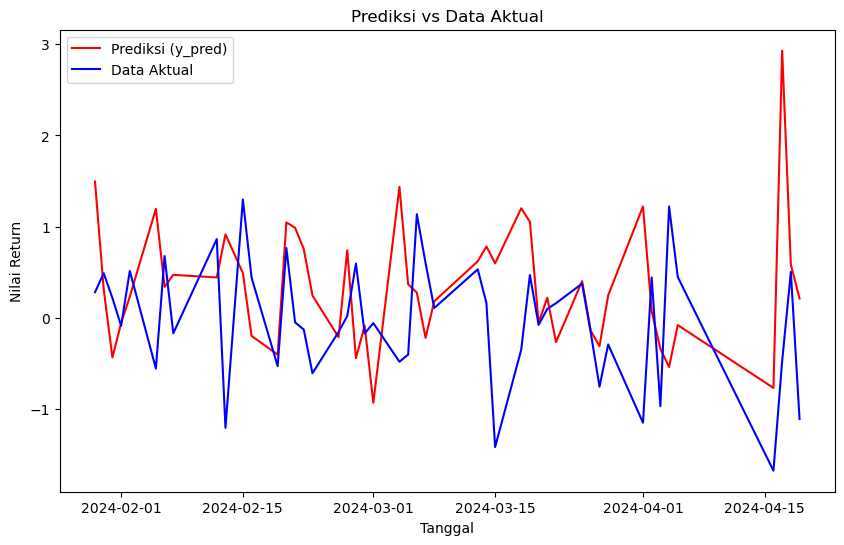

In [113]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(validation_data.index, y_val_pred, label='Prediksi (y_pred)', color='red')
plt.plot(validation_data.index, validation_data['Return(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Return')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()

In [114]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Define model
model = SVR()
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.01, 0.001],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform hyperparameter tuning
grid_search.fit(X_train_scaled, train_data['Open(t)'])

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_val_scaled)
rmse = mean_squared_error(validation_data['Open(t)'], y_pred,squared=False)
print("Best Parameters:", best_params)
print("Best Model RMSE:", rmse)

Best Parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Model RMSE: 329.8713855685569
